In [1]:
!nvidia-smi

Mon Dec 29 01:35:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Install additional dependencies

In [2]:
%pip install transformers datasets soundfile speechbrain accelerate torchcodec

Sign into huggingface

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Load the data

In [4]:
from datasets import load_dataset, Audio

dataset = load_dataset("jspaulsen/vctk", split="train")
len(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/36 [00:00<?, ?it/s]

88156

Cast sampling rate to 16khz that SpeechT5 expects

In [5]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Load the processor for SpeechT5

In [6]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

## Text cleanup for SpeechT5 Tokenization

First get the tokenizer for speechT5 that is part of the processor object

In [7]:
tokenizer = processor.tokenizer

Inspect a sample from the dataset

In [8]:
dataset[0]

{'id': 'p247_215_mic1',
 'text': 'And they were being paid?',
 'speaker_id': 'p247',
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x7d8ec1915e50>,
 'mic_id': 'mic1'}

Tokenize the dataset to inspect for any characters unknown to the tokenizer

In [9]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/88156 [00:00<?, ? examples/s]

Identify and output any characters in the dataset that are unknown to the tokenizer but present in the dataset

In [10]:
dataset_vocab - tokenizer_vocab

{'\t', ' ', '`'}

Clean up the unknown characters

In [11]:
replacements = [
    ("\t", " "),
    ("`", " "),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["text"] = inputs["text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

## Understand the Speaker breakdown of the dataset

Get the speaker count for the dataset

In [12]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

Plot a histogram showing the breakdown of data by speaker

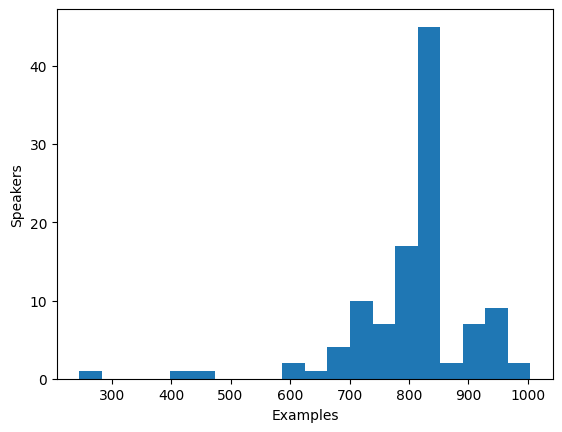

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

Limit the dataset for speakers between 600 and 900 examples for training efficiency

In [14]:
def select_speaker(speaker_id):
    return 600 <= speaker_counts[speaker_id] <= 900


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Check how many speakers remain

In [15]:
len(set(dataset["speaker_id"]))

88

Check how many total examples remain

In [16]:
len(dataset)

70106

## Speaker Embeddings

Create speaker embeddings to pass into SpeechT5 during training

In [17]:
import os
import torch

# fix to get around torchaudio issue on some platforms
import torchaudio

if not hasattr(torchaudio, "list_audio_backends"):
    torchaudio.list_audio_backends = lambda: [""]  # type: ignore
# end fix

from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
DEBUG:speechbrain.utils.checkpoints:Regi

hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/hyperparams.yaml' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.12/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook fo

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/embedding_model.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/mean_var_norm_emb.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/classifier.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /tmp/speechbrain/spkrec-xvect-voxceleb/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/label_encoder.txt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /tmp/speechbrain/spkrec-xvect-voxceleb/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /tmp/speechbra

## Process the Dataset

Create a function that prepares the dataset by taking in a single example and does two things:

1. tokenizes the input text
2. load the target audio in as a log-mel spectrogram

In [21]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    # calculate stop labels
    target_length = len(example["labels"])

    # Create stop labels
    example["stop_labels"] = [0] * (target_length - 1) + [1]

    return example

Verify the function works on a single example

In [22]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings', 'stop_labels']

In [23]:
processed_example["speaker_embeddings"].shape

(512,)

Inspect the resulting spectrogram (spectrograms appear upside down in the matplotlib library)

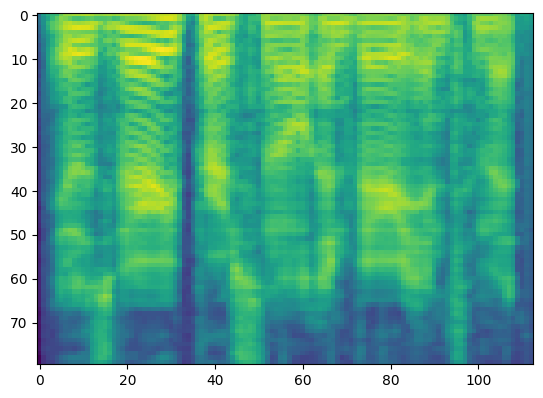

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

Now that we've verified the processing function is working correctly we can apply it to the whole dataset!

In [ ]:
# take only first 10k samples for training
dataset = dataset.shuffle().select(range(10000))

dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/70106 [00:00<?, ? examples/s]

Remove anything over 200 tokens for example fine tuning like this

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/70106 [00:00<?, ? examples/s]

10000

Create a train/test split

In [28]:
dataset = dataset.train_test_split(test_size=0.1)

## Data Collator
Create a custom data collator to pad batched samples, and replace padded portions with `-100` so they are ignored when loss is calculated

In [29]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [30]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

## Train the Model

Load the pretrained SpeechT5 model

In [31]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

Disable caching for generation but re-enable for generation (due to caching being incompatible with gradient checkpointing)

In [41]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

Define the training arguments.

*Note: evaluation can be weird for TTS models since it is fundamentally a 1:many mapping problem (ie a single input can have practically infinite correct outputs in terms of accents, genders, dialects, etc)*

In [46]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_vctk",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

Instantiate the `Trainer` object

In [47]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/tmp/ipython-input-1231872571.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Begin training!

In [48]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.507800,0.471789
2000,0.484300,0.454131
3000,0.476900,0.449370
4000,0.474600,0.447267


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=4000, training_loss=0.5363981575965882, metrics={'train_runtime': 6945.1008, 'train_samples_per_second': 18.43, 'train_steps_per_second': 0.576, 'total_flos': 6740702019554976.0, 'train_loss': 0.5363981575965882, 'epoch': 14.184888888888889})

Define kwargs to push model to hub

In [49]:
kwargs = {
    "dataset_tags": "jspaulsen/vctk",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
}

Push model to the hub

In [50]:
trainer.push_to_hub(**kwargs)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ed_vctk/training_args.bin: 100%|##########| 6.03kB / 6.03kB            

  ...5999.68eb719a12a0.14918.0: 100%|##########| 6.63kB / 6.63kB            

  ...6048.68eb719a12a0.14918.1: 100%|##########| 13.2kB / 13.2kB            

  ...6229.68eb719a12a0.14918.2: 100%|##########| 6.63kB / 6.63kB            

  ...tuned_vctk/spm_char.model: 100%|##########|  238kB /  238kB            

  ...6336.68eb719a12a0.14918.3: 100%|##########| 41.8kB / 41.8kB            

  ...ed_vctk/model.safetensors:   4%|4         | 25.2MB /  578MB            

CommitInfo(commit_url='https://huggingface.co/dzur658/speecht5_finetuned_vctk/commit/d16a000ceea3d5311ea52ab814b57d4269a78c95', commit_message='End of training', commit_description='', oid='d16a000ceea3d5311ea52ab814b57d4269a78c95', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dzur658/speecht5_finetuned_vctk', endpoint='https://huggingface.co', repo_type='model', repo_id='dzur658/speecht5_finetuned_vctk'), pr_revision=None, pr_num=None)